In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Carregamento arquivo de pré-processamento

In [2]:
%run "/content/drive/My Drive/pre_processamento_TCC.ipynb"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
CPU times: user 1min 53s, sys: 11.5 s, total: 2min 4s
Wall time: 2min 13s
Ataque de exploração UDPLag:  Label
BENIGN       3705
UDP-lag    366461
dtype: int64 

Ataque de exploração Syn:  Label
BENIGN        392
Syn       1582289
dtype: int64 

Ataque de exploração LDAP:  Label
BENIGN           1612
DrDoS_LDAP    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
BENIGN              1707
DrDoS_NetBIOS    4093279
dtype: int64
Ataque de exploração UDPLag:  Label
0      3705
1    366461
dtype: int64 

Ataque de exploração Syn:  Label
0        392
1    1582289
dtype: int64 

Ataque de exploração LDAP:  Label
0       1612
1    2179930
dtype: int64 

Ataque de exploração NetBIOS:  Label
0       1707
1    4093279
dtype: int64


In [3]:
netbios = netbios.sample(333763)
print(netbios.groupby(by=' Label').size())

 Label
0       143
1    333620
dtype: int64


### Bibliotecas


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

### Divisão do conjunto em treino e teste


In [5]:
netbios

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
41388,1,2,0,910.0,0.0,455.0,455.0,455.0,0.0,0.0,0.0,0.0,0.0,9.100000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.0,455.0,455.0,455.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,682.5,455.0,0.0,40,0,0,0,0,0,0,2,910,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
626444,2,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,2.290000e+08,1.000000e+06,2.0,0.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,1.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3325902,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,9.346939e+06,4.081633e+04,49.0,0.0,49.0,49.0,49.0,49.0,0.0,49.0,49.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,4.081633e+04,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
950086,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2778303,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467287,48,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,9.541667e+06,4.166667e+04,48.0,0.0,48.0,48.0,48.0,48.0,0.0,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,-2125437950,0,4.166667e+04,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,-2125437950,0,0,0,0,0,0,2,458,0,0,-1,-1,1,-1062718975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
894804,49,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,9.346939e+06,4.081633e+04,49.0,0.0,49.0,49.0,49.0,49.0,0.0,49.0,49.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,4.081633e+04,0.0,229.0,229.0,229.0,0.0,0.0,0,0,0,0,0,0,0,0,0.0,343.5,229.0,0.0,40,0,0,0,0,0,0,2,458,0,0,-1,-1,1,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3759011,1,2,0,458.0,0.0,229.0,229.0,229.0,0.0,0.0,0.0,0.0,0.0,4.580000e+08,2.000000e+06,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,40,0,2.000000e+06,0.0,229.0,229.0,229.0,0.0,0.0,0,

Preparação dos dados treino e teste


In [6]:
X = netbios.iloc[:, 0:77]
y = netbios.iloc[:,- 1]

70% para treino, 30% para teste

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=0.3,
                                                    random_state=42)

In [8]:
# Formato dos dados de entrada
print('Formato dos dados de entrada:', x_train.shape)

# Tamanho dos conjuntos
print('Amostras de treino: ', x_train.shape[0])
print('Amostras de teste: ', x_test.shape[0])

Formato dos dados de entrada: (233634, 77)
Amostras de treino:  233634
Amostras de teste:  100129


### Seleção dos Parâmetro
Seleção dos 15 melhores parâmetros.

In [9]:
best_features = SelectKBest(score_func=f_classif, k=15)
fit = best_features.fit(x_train,y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(x_train.columns)
# concatenar quadros de dados
feature_scores = pd.concat([df_columns, df_scores],axis=1)
feature_scores.columns = ['Feature_Name','Score']  # colunas de saída de nome
print(feature_scores.nlargest(15,'Score'))  # imprima 15 melhores parâmetros

               Feature_Name          Score
47           URG Flag Count  127346.283564
50            Down/Up Ratio  101061.155150
10    Bwd Packet Length Min   90308.933082
29            Fwd PSH Flags   56958.536798
44           RST Flag Count   56958.536798
11   Bwd Packet Length Mean   50644.912608
53     Avg Bwd Segment Size   50644.912608
40        Packet Length Std   43445.053415
9     Bwd Packet Length Max   40127.203132
2    Total Backward Packets   39620.067290
63      Subflow Bwd Packets   39620.067290
48           CWE Flag Count   35797.713300
12    Bwd Packet Length Std   32472.239061
25             Bwd IAT Mean   32442.267261
41   Packet Length Variance   28620.092814


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [30 31 32 42 43 45 49 55 56 57 58 59 60] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [10]:
feature = feature_scores.nlargest(15,'Score')
feature

,Feature_Name,Score
47,URG Flag Count,127346.283564
50,Down/Up Ratio,101061.155150
10,Bwd Packet Length Min,90308.933082
29,Fwd PSH Flags,56958.536798
44,RST Flag Count,56958.536798
11,Bwd Packet Length Mean,50644.912608
53,Avg Bwd Segment Size,50644.912608
40,Packet Length Std,43445.053415
9,Bwd Packet Length Max,40127.203132
2,Total Backward Packets,39620.067290


Exlusão dos parâmetros que não seram usados no modelo.


In [11]:
netbios.columns

Index([' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       'FIN Flag Count', ' SY

In [12]:
x_train = x_train.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

x_test = x_test.drop(columns=[' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets','Total Length of Fwd Packets', 
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max', 
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', ' Bwd PSH Flags', 
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', 
       'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', 
       ' Max Packet Length', ' Packet Length Mean', 'FIN Flag Count', 
       ' SYN Flag Count', ' PSH Flag Count', ' ACK Flag Count', 
       ' ECE Flag Count', ' Average Packet Size', ' Avg Fwd Segment Size',
       ' Fwd Header Length.1', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', 
       ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 
       'Bwd Avg Bulk Rate', 'Subflow Fwd Packets', ' Subflow Fwd Bytes', 
       ' Subflow Bwd Packets', ' Subflow Bwd Bytes', 'Init_Win_bytes_forward',
       ' act_data_pkt_fwd', ' min_seg_size_forward', 'Active Mean', 
       ' Active Std', ' Active Max', ' Active Min', 'Idle Mean', ' Idle Std',
       ' Idle Max', ' Idle Min'], axis= 1)

### Normalização dos dados

In [13]:
normalizador = MinMaxScaler()
x_train= normalizador.fit_transform(x_train)
x_test = normalizador.fit_transform(x_test)
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

### Formatação do tensor em 3D

In [14]:
x_train= x_train.reshape(-1, 233634, 15)
y_train= y_train.reshape(-1, 233634, 1)
x_test = x_test.reshape(-1, 100129, 15)
y_test = y_test.reshape(-1, 100129, 1)

In [15]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1, 233634, 15)
(1, 233634, 1)
(1, 100129, 15)
(1, 100129, 1)


### Rede Neural Recorrente (LSTM)

#### Experimento 1

In [16]:
%%time
model1 = Sequential()
model1.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

model1.add(LSTM(units = 10, return_sequences = True))
model1.add(Dropout(0.3))

# Camada Final
model1.add(Dense(1, activation='sigmoid'))

# Compile model
model1.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model1.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2716 - accuracy: 0.1412 - auc: 0.5044 - recall: 0.1409 - precision: 0.9993 - root_mean_squared_error: 0.5212 - val_loss: 0.2430 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4930
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2479 - accuracy: 0.5677 - auc: 0.5269 - recall: 0.5677 - precision: 0.9996 - root_mean_squared_error: 0.4979 - val_loss: 0.2379 - val_accuracy: 0.9996 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4877
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2328 - accuracy: 0.9822 - auc: 0.4926 - recall: 0.9826 - precision: 0.9996 - root_mean_squared_error: 0.4825 - val_loss: 0.2325 - val_accuracy: 0.9996 - val_auc: 0.4991 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4822
Epoch 4/50
1/1 [===============

In [17]:
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 233634, 20)        2880      
_________________________________________________________________
dropout (Dropout)            (None, 233634, 20)        0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_1 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_2 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 233634, 10)        8

In [18]:
checkpointer1 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer1], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02492, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0256 - accuracy: 0.9996 - auc: 0.4666 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1599 - val_loss: 0.0249 - val_accuracy: 0.9996 - val_auc: 0.5059 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1579
Epoch 2/50

Epoch 00002: val_loss improved from 0.02492 to 0.02406, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0249 - accuracy: 0.9996 - auc: 0.5152 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1578 - val_loss: 0.0241 - val_accuracy: 0.9996 - val_auc: 0.5018 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1551
Epoch 3/50

Epoch 00003: val_loss improved from 0.02406 to 0.02323, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0243 - accuracy: 0.9996 - auc: 0.4784 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1559 - val_loss

In [19]:
scores1 = model1.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores1[0]*100))
print("Acurácia: %.2f%%" % (scores1[1]*100))
print("AUC: %.2f%%" % (scores1[2]*100))
print("Recall: %.2f%%" % (scores1[3]*100))
print("Precision: %.2f%%" % (scores1[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores1[5]*100))

LDAP
Loss: 0.45%
Acurácia: 99.96%
AUC: 49.97%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 6.69%


#### Experimento 2

In [20]:
%%time
model2 = Sequential()
model2.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

model2.add(LSTM(units = 10, return_sequences = True))
model2.add(Dropout(0.3))

# Camada Final
model2.add(Dense(1, activation='sigmoid'))

# Compile model
model2.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model2.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2574 - accuracy: 0.1916 - auc: 0.5367 - recall: 0.1913 - precision: 0.9997 - root_mean_squared_error: 0.5074 - val_loss: 0.2429 - val_accuracy: 0.9996 - val_auc: 0.5002 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4929
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2405 - accuracy: 0.9109 - auc: 0.4904 - recall: 0.9112 - precision: 0.9996 - root_mean_squared_error: 0.4904 - val_loss: 0.2376 - val_accuracy: 0.9996 - val_auc: 0.4553 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4875
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2285 - accuracy: 0.9935 - auc: 0.5034 - recall: 0.9939 - precision: 0.9996 - root_mean_squared_error: 0.4780 - val_loss: 0.2323 - val_accuracy: 0.9996 - val_auc: 0.4979 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4820
Epoch 4/50
1/1 [===============

In [21]:
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_4 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 233634, 10)        840       
_________________________________________________________________
dropout_6 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 233634, 10)       

In [22]:
checkpointer2 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer2], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00791, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0103 - accuracy: 0.9996 - auc: 0.4616 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1017 - val_loss: 0.0079 - val_accuracy: 0.9996 - val_auc: 0.5029 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0890
Epoch 2/50

Epoch 00002: val_loss improved from 0.00791 to 0.00757, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0100 - accuracy: 0.9996 - auc: 0.5168 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1001 - val_loss: 0.0076 - val_accuracy: 0.9996 - val_auc: 0.4993 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0870
Epoch 3/50

Epoch 00003: val_loss improved from 0.00757 to 0.00724, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0098 - accuracy: 0.9996 - auc: 0.5080 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0991 - val_loss

In [23]:
scores2 = model2.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores2[0]*100))
print("Acurácia: %.2f%%" % (scores2[1]*100))
print("AUC: %.2f%%" % (scores2[2]*100))
print("Recall: %.2f%%" % (scores2[3]*100))
print("Precision: %.2f%%" % (scores2[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores2[5]*100))

LDAP
Loss: 0.13%
Acurácia: 99.96%
AUC: 49.99%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.65%


#### Experimento 3

In [24]:
%%time
model3 = Sequential()
model3.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

model3.add(LSTM(units = 10, return_sequences = True))
model3.add(Dropout(0.3))

# Camada Final
model3.add(Dense(1, activation='sigmoid'))

# Compile model
model3.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model3.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2375 - accuracy: 0.9087 - auc: 0.4899 - recall: 0.9091 - precision: 0.9996 - root_mean_squared_error: 0.4873 - val_loss: 0.2419 - val_accuracy: 0.9996 - val_auc: 0.5000 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4918
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2162 - accuracy: 0.9976 - auc: 0.4851 - recall: 0.9980 - precision: 0.9996 - root_mean_squared_error: 0.4650 - val_loss: 0.2347 - val_accuracy: 0.9996 - val_auc: 0.5020 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4844
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.1971 - accuracy: 0.9989 - auc: 0.5222 - recall: 0.9993 - precision: 0.9996 - root_mean_squared_error: 0.4439 - val_loss: 0.2272 - val_accuracy: 0.9996 - val_auc: 0.5012 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4766
Epoch 4/50
1/1 [===============

In [25]:
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 233634, 20)        2880      
_________________________________________________________________
dropout_8 (Dropout)          (None, 233634, 20)        0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 233634, 10)        1240      
_________________________________________________________________
dropout_9 (Dropout)          (None, 233634, 10)        0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_10 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 233634, 10)       

In [26]:
checkpointer3 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist3 = model3.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer3], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00944, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0132 - accuracy: 0.9996 - auc: 0.5199 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1151 - val_loss: 0.0094 - val_accuracy: 0.9996 - val_auc: 0.5010 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0972
Epoch 2/50

Epoch 00002: val_loss improved from 0.00944 to 0.00895, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0129 - accuracy: 0.9996 - auc: 0.4416 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1136 - val_loss: 0.0090 - val_accuracy: 0.9996 - val_auc: 0.5064 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0946
Epoch 3/50

Epoch 00003: val_loss improved from 0.00895 to 0.00849, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0125 - accuracy: 0.9996 - auc: 0.5275 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1118 - val_loss

In [27]:
scores3 = model3.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores3[0]*100))
print("Acurácia: %.2f%%" % (scores3[1]*100))
print("AUC: %.2f%%" % (scores3[2]*100))
print("Recall: %.2f%%" % (scores3[3]*100))
print("Precision: %.2f%%" % (scores3[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores3[5]*100))

LDAP
Loss: 0.14%
Acurácia: 99.96%
AUC: 49.98%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.74%


#### Experimento 4

In [28]:
%%time
model4 = Sequential()
model4.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

model4.add(LSTM(units = 10, return_sequences = True))
model4.add(Dropout(0.3))

# Camada Final
model4.add(Dense(1, activation='sigmoid'))

# Compile model
model4.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model4.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2301 - accuracy: 0.9925 - auc: 0.4750 - recall: 0.9929 - precision: 0.9996 - root_mean_squared_error: 0.4797 - val_loss: 0.2414 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4913
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2101 - accuracy: 0.9980 - auc: 0.5464 - recall: 0.9984 - precision: 0.9996 - root_mean_squared_error: 0.4584 - val_loss: 0.2341 - val_accuracy: 0.9996 - val_auc: 0.5004 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4838
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.1936 - accuracy: 0.9987 - auc: 0.4963 - recall: 0.9992 - precision: 0.9996 - root_mean_squared_error: 0.4399 - val_loss: 0.2270 - val_accuracy: 0.9996 - val_auc: 0.4998 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4764
Epoch 4/50
1/1 [===============

In [29]:
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_12 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_13 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_14 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 233634, 10)       

In [30]:
checkpointer4 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist4 = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer4], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.02121, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0190 - accuracy: 0.9996 - auc: 0.5001 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1379 - val_loss: 0.0212 - val_accuracy: 0.9996 - val_auc: 0.4967 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1457
Epoch 2/50

Epoch 00002: val_loss improved from 0.02121 to 0.02027, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0185 - accuracy: 0.9996 - auc: 0.5145 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1362 - val_loss: 0.0203 - val_accuracy: 0.9996 - val_auc: 0.5033 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1424
Epoch 3/50

Epoch 00003: val_loss improved from 0.02027 to 0.01937, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0182 - accuracy: 0.9996 - auc: 0.4736 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1350 - val_loss

In [31]:
scores4 = model4.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores4[0]*100))
print("Acurácia: %.2f%%" % (scores4[1]*100))
print("AUC: %.2f%%" % (scores4[2]*100))
print("Recall: %.2f%%" % (scores4[3]*100))
print("Precision: %.2f%%" % (scores4[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores4[5]*100))

LDAP
Loss: 0.31%
Acurácia: 99.96%
AUC: 49.98%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 5.60%


#### Experimento 5

In [32]:
%%time
model5 = Sequential()
model5.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

model5.add(LSTM(units = 10, return_sequences = True))
model5.add(Dropout(0.3))

# Camada Final
model5.add(Dense(1, activation='sigmoid'))

# Compile model
model5.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model5.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 6s 6s/step - loss: 0.2650 - accuracy: 0.1579 - auc: 0.4831 - recall: 0.1576 - precision: 0.9996 - root_mean_squared_error: 0.5147 - val_loss: 0.2402 - val_accuracy: 0.9996 - val_auc: 0.4994 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4901
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2385 - accuracy: 0.8253 - auc: 0.5111 - recall: 0.8256 - precision: 0.9995 - root_mean_squared_error: 0.4883 - val_loss: 0.2322 - val_accuracy: 0.9996 - val_auc: 0.4979 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4819
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2192 - accuracy: 0.9667 - auc: 0.5551 - recall: 0.9671 - precision: 0.9996 - root_mean_squared_error: 0.4682 - val_loss: 0.2242 - val_accuracy: 0.9996 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4735
Epoch 4/50
1/1 [===============

In [33]:
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_16 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_17 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_18 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 233634, 10)       

In [34]:
checkpointer5 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist5 = model5.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer5], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00740, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0142 - accuracy: 0.9996 - auc: 0.4665 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1193 - val_loss: 0.0074 - val_accuracy: 0.9996 - val_auc: 0.4996 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0860
Epoch 2/50

Epoch 00002: val_loss improved from 0.00740 to 0.00704, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0138 - accuracy: 0.9996 - auc: 0.5259 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1176 - val_loss: 0.0070 - val_accuracy: 0.9996 - val_auc: 0.4997 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0839
Epoch 3/50

Epoch 00003: val_loss improved from 0.00704 to 0.00671, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0133 - accuracy: 0.9996 - auc: 0.4958 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1155 - val_loss

In [35]:
scores5 = model5.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores5[0]*100))
print("Acurácia: %.2f%%" % (scores5[1]*100))
print("AUC: %.2f%%" % (scores5[2]*100))
print("Recall: %.2f%%" % (scores5[3]*100))
print("Precision: %.2f%%" % (scores5[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores5[5]*100))

LDAP
Loss: 0.12%
Acurácia: 99.96%
AUC: 49.98%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.42%


#### Experimento 6

In [36]:
%%time
model6 = Sequential()
model6.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

model6.add(LSTM(units = 10, return_sequences = True))
model6.add(Dropout(0.3))

# Camada Final
model6.add(Dense(1, activation='sigmoid'))

# Compile model
model6.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model6.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2383 - accuracy: 0.9807 - auc: 0.4636 - recall: 0.9811 - precision: 0.9996 - root_mean_squared_error: 0.4881 - val_loss: 0.2435 - val_accuracy: 0.9996 - val_auc: 0.5021 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4935
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2231 - accuracy: 0.9971 - auc: 0.4711 - recall: 0.9975 - precision: 0.9996 - root_mean_squared_error: 0.4724 - val_loss: 0.2371 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4870
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2061 - accuracy: 0.9985 - auc: 0.5113 - recall: 0.9989 - precision: 0.9996 - root_mean_squared_error: 0.4540 - val_loss: 0.2297 - val_accuracy: 0.9996 - val_auc: 0.5025 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4792
Epoch 4/50
1/1 [===============

In [37]:
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_20 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_21 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 233634, 10)       

In [38]:
checkpointer6 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist6 = model6.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer6], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01096, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0158 - accuracy: 0.9996 - auc: 0.4591 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1256 - val_loss: 0.0110 - val_accuracy: 0.9996 - val_auc: 0.5034 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1047
Epoch 2/50

Epoch 00002: val_loss improved from 0.01096 to 0.01048, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0154 - accuracy: 0.9996 - auc: 0.4808 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1240 - val_loss: 0.0105 - val_accuracy: 0.9996 - val_auc: 0.3796 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1024
Epoch 3/50

Epoch 00003: val_loss improved from 0.01048 to 0.01002, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0149 - accuracy: 0.9996 - auc: 0.5371 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1222 - val_loss

In [39]:
scores6 = model6.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores6[0]*100))
print("Acurácia: %.2f%%" % (scores6[1]*100))
print("AUC: %.2f%%" % (scores6[2]*100))
print("Recall: %.2f%%" % (scores6[3]*100))
print("Precision: %.2f%%" % (scores6[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores6[5]*100))

LDAP
Loss: 0.22%
Acurácia: 99.96%
AUC: 49.98%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 4.65%


#### Experimento 7

In [40]:
%%time
model7 = Sequential()
model7.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

model7.add(LSTM(units = 10, return_sequences = True))
model7.add(Dropout(0.3))

# Camada Final
model7.add(Dense(1, activation='sigmoid'))

# Compile model
model7.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model7.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2641 - accuracy: 0.2466 - auc: 0.4502 - recall: 0.2464 - precision: 0.9994 - root_mean_squared_error: 0.5139 - val_loss: 0.2391 - val_accuracy: 0.9996 - val_auc: 0.5013 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4889
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2258 - accuracy: 0.8932 - auc: 0.4756 - recall: 0.8935 - precision: 0.9996 - root_mean_squared_error: 0.4752 - val_loss: 0.2304 - val_accuracy: 0.9996 - val_auc: 0.5009 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4800
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.1990 - accuracy: 0.9807 - auc: 0.5159 - recall: 0.9811 - precision: 0.9996 - root_mean_squared_error: 0.4461 - val_loss: 0.2220 - val_accuracy: 0.9996 - val_auc: 0.5006 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4712
Epoch 4/50
1/1 [===============

In [41]:
print(model7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_24 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_25 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_26 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 233634, 10)       

In [42]:
checkpointer7 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist7 = model7.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer7], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.00632, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0073 - accuracy: 0.9996 - auc: 0.5037 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0856 - val_loss: 0.0063 - val_accuracy: 0.9996 - val_auc: 0.5037 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0795
Epoch 2/50

Epoch 00002: val_loss improved from 0.00632 to 0.00584, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0070 - accuracy: 0.9996 - auc: 0.4779 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0837 - val_loss: 0.0058 - val_accuracy: 0.9996 - val_auc: 0.5007 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.0764
Epoch 3/50

Epoch 00003: val_loss improved from 0.00584 to 0.00540, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0067 - accuracy: 0.9996 - auc: 0.5070 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0820 - val_loss

In [43]:
scores7 = model7.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores7[0]*100))
print("Acurácia: %.2f%%" % (scores7[1]*100))
print("AUC: %.2f%%" % (scores7[2]*100))
print("Recall: %.2f%%" % (scores7[3]*100))
print("Precision: %.2f%%" % (scores7[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores7[5]*100))

LDAP
Loss: 0.08%
Acurácia: 99.96%
AUC: 49.97%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 2.78%


#### Experimento 8

In [44]:
%%time
model8 = Sequential()
model8.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

model8.add(LSTM(units = 10, return_sequences = True))
model8.add(Dropout(0.3))

# Camada Final
model8.add(Dense(1, activation='sigmoid'))

# Compile model
model8.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model8.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2513 - accuracy: 0.4745 - auc: 0.4754 - recall: 0.4745 - precision: 0.9995 - root_mean_squared_error: 0.5013 - val_loss: 0.2431 - val_accuracy: 0.9996 - val_auc: 0.5012 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4930
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2328 - accuracy: 0.7969 - auc: 0.5310 - recall: 0.7971 - precision: 0.9996 - root_mean_squared_error: 0.4825 - val_loss: 0.2372 - val_accuracy: 0.9996 - val_auc: 0.4990 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4871
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2177 - accuracy: 0.8950 - auc: 0.5246 - recall: 0.8953 - precision: 0.9996 - root_mean_squared_error: 0.4665 - val_loss: 0.2315 - val_accuracy: 0.9996 - val_auc: 0.4997 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4812
Epoch 4/50
1/1 [===============

In [45]:
print(model8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_28 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_29 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_30 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 233634, 10)       

In [46]:
checkpointer8 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist8 = model8.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer8], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01571, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0216 - accuracy: 0.9996 - auc: 0.4504 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1468 - val_loss: 0.0157 - val_accuracy: 0.9996 - val_auc: 0.5020 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1253
Epoch 2/50

Epoch 00002: val_loss improved from 0.01571 to 0.01488, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0208 - accuracy: 0.9996 - auc: 0.4885 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1443 - val_loss: 0.0149 - val_accuracy: 0.9996 - val_auc: 0.3147 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1220
Epoch 3/50

Epoch 00003: val_loss improved from 0.01488 to 0.01411, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0201 - accuracy: 0.9996 - auc: 0.5231 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1419 - val_loss

In [47]:
scores8 = model8.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores8[0]*100))
print("Acurácia: %.2f%%" % (scores8[1]*100))
print("AUC: %.2f%%" % (scores8[2]*100))
print("Recall: %.2f%%" % (scores8[3]*100))
print("Precision: %.2f%%" % (scores8[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores8[5]*100))

LDAP
Loss: 0.28%
Acurácia: 99.96%
AUC: 49.98%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 5.25%


#### Experimento 9

In [48]:
%%time
model9 = Sequential()
model9.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

model9.add(LSTM(units = 10, return_sequences = True))
model9.add(Dropout(0.3))

# Camada Final
model9.add(Dense(1, activation='sigmoid'))

# Compile model
model9.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model9.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2511 - accuracy: 0.4542 - auc: 0.5257 - recall: 0.4542 - precision: 0.9996 - root_mean_squared_error: 0.5011 - val_loss: 0.2409 - val_accuracy: 0.9996 - val_auc: 0.4994 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4908
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2270 - accuracy: 0.9794 - auc: 0.4799 - recall: 0.9798 - precision: 0.9996 - root_mean_squared_error: 0.4764 - val_loss: 0.2336 - val_accuracy: 0.9996 - val_auc: 0.5024 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4833
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2086 - accuracy: 0.9967 - auc: 0.4950 - recall: 0.9971 - precision: 0.9996 - root_mean_squared_error: 0.4567 - val_loss: 0.2267 - val_accuracy: 0.9996 - val_auc: 0.4995 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4761
Epoch 4/50
1/1 [===============

In [49]:
print(model9.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_32 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_33 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_34 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_35 (LSTM)               (None, 233634, 10)       

In [50]:
checkpointer9 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist9 = model9.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer9], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01361, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0099 - accuracy: 0.9996 - auc: 0.5093 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0994 - val_loss: 0.0136 - val_accuracy: 0.9996 - val_auc: 0.5015 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1167
Epoch 2/50

Epoch 00002: val_loss improved from 0.01361 to 0.01281, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0094 - accuracy: 0.9996 - auc: 0.4929 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0971 - val_loss: 0.0128 - val_accuracy: 0.9996 - val_auc: 0.5096 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1132
Epoch 3/50

Epoch 00003: val_loss improved from 0.01281 to 0.01205, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0091 - accuracy: 0.9996 - auc: 0.4397 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.0952 - val_loss

In [51]:
scores9 = model9.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores9[0]*100))
print("Acurácia: %.2f%%" % (scores9[1]*100))
print("AUC: %.2f%%" % (scores9[2]*100))
print("Recall: %.2f%%" % (scores9[3]*100))
print("Precision: %.2f%%" % (scores9[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores9[5]*100))

LDAP
Loss: 0.13%
Acurácia: 99.96%
AUC: 49.97%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 3.58%


#### Experimento 10

In [52]:
%%time
model10 = Sequential()
model10.add(LSTM(units = 20, return_sequences = True, input_shape=(233634, 15)))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

model10.add(LSTM(units = 10, return_sequences = True))
model10.add(Dropout(0.3))

# Camada Final
model10.add(Dense(1, activation='sigmoid'))

# Compile model
model10.compile(optimizer = 'RMSprop', loss = 'mean_squared_error',
                  metrics=['accuracy', 'AUC', 'Recall', 'Precision', 'RootMeanSquaredError'])
# Fit the model
model10.fit(x_train,y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/50
1/1 [==============================] - 5s 5s/step - loss: 0.2505 - accuracy: 0.4531 - auc: 0.5229 - recall: 0.4531 - precision: 0.9996 - root_mean_squared_error: 0.5005 - val_loss: 0.2410 - val_accuracy: 0.9996 - val_auc: 0.4999 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4909
Epoch 2/50
1/1 [==============================] - 4s 4s/step - loss: 0.2255 - accuracy: 0.9149 - auc: 0.5173 - recall: 0.9153 - precision: 0.9996 - root_mean_squared_error: 0.4749 - val_loss: 0.2335 - val_accuracy: 0.9996 - val_auc: 0.5035 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4832
Epoch 3/50
1/1 [==============================] - 4s 4s/step - loss: 0.2078 - accuracy: 0.9639 - auc: 0.5152 - recall: 0.9643 - precision: 0.9996 - root_mean_squared_error: 0.4559 - val_loss: 0.2261 - val_accuracy: 0.9996 - val_auc: 0.5003 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.4755
Epoch 4/50
1/1 [===============

In [53]:
print(model10.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 233634, 20)        2880      
_________________________________________________________________
dropout_36 (Dropout)         (None, 233634, 20)        0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 233634, 10)        1240      
_________________________________________________________________
dropout_37 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 233634, 10)        840       
_________________________________________________________________
dropout_38 (Dropout)         (None, 233634, 10)        0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 233634, 10)       

In [54]:
checkpointer10 = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)
hist10 = model10.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50, batch_size=32, callbacks=[checkpointer10], verbose = 2)

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.01786, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0226 - accuracy: 0.9996 - auc: 0.5147 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1502 - val_loss: 0.0179 - val_accuracy: 0.9996 - val_auc: 0.5017 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1336
Epoch 2/50

Epoch 00002: val_loss improved from 0.01786 to 0.01669, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0217 - accuracy: 0.9996 - auc: 0.5156 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1475 - val_loss: 0.0167 - val_accuracy: 0.9996 - val_auc: 0.5011 - val_recall: 1.0000 - val_precision: 0.9996 - val_root_mean_squared_error: 0.1292
Epoch 3/50

Epoch 00003: val_loss improved from 0.01669 to 0.01560, saving model to model.weights.best.hdf5
1/1 - 4s - loss: 0.0211 - accuracy: 0.9996 - auc: 0.4624 - recall: 1.0000 - precision: 0.9996 - root_mean_squared_error: 0.1452 - val_loss

In [55]:
scores10 = model10.evaluate(x_test, y_test, verbose=0)
print('LDAP')
print("Loss: %.2f%%" % (scores10[0]*100))
print("Acurácia: %.2f%%" % (scores10[1]*100))
print("AUC: %.2f%%" % (scores10[2]*100))
print("Recall: %.2f%%" % (scores10[3]*100))
print("Precision: %.2f%%" % (scores10[4]*100))
print("RootMeanSquaredError: %.2f%%" % (scores10[5]*100))

LDAP
Loss: 0.23%
Acurácia: 99.96%
AUC: 49.97%
Recall: 100.00%
Precision: 99.96%
RootMeanSquaredError: 4.81%


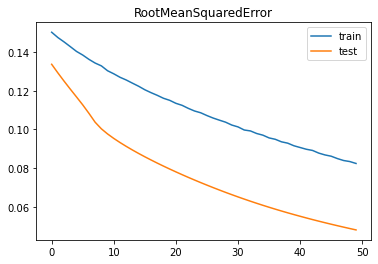

In [56]:
plt.title('RootMeanSquaredError')
plt.plot(hist10.history['root_mean_squared_error'], label='train')
plt.plot(hist10.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show();